[![Roboflow Notebooks](https://media.roboflow.com/notebooks/template/bannertest2-2.png?ik-sdk-version=javascript-1.4.3&updatedAt=1672932710194)](https://github.com/roboflow/notebooks)

# Fine-tune PaliGemma on Object Detection Dataset

---

[![GitHub](https://badges.aleen42.com/src/github.svg)](https://github.com/google-research/big_vision/blob/main/big_vision/configs/proj/paligemma/README.md)
[![Roboflow](https://raw.githubusercontent.com/roboflow-ai/notebooks/main/assets/badges/roboflow-blogpost.svg)](https://blog.roboflow.com/how-to-fine-tune-paligemma/)

PaliGemma is an open vision-language model (VLM) inspired by PaLI-3, built with
open components, such as
the [SigLIP vision model](https://colab.research.google.com/github/google-research/big_vision/blob/main/big_vision/configs/proj/image_text/SigLIP_demo.ipynb)
and
the [Gemma language model](https://ai.google.dev/gemma).
PaliGemma is designed as a versatile model for transfer to a wide range of
vision-language tasks such as image and short video caption, visual question
answering, text reading, object detection and object segmentation. Together with
the pretrained and transfer checkpoints at multiple resolutions, we provide a
checkpoint transferred to a mixture of tasks that can be used for off-the-shelf
exploration.

This notebook is an extension of the [official notebook](https://colab.research.google.com/github/google-research/big_vision/blob/main/big_vision/configs/proj/paligemma/finetune_paligemma.ipynb) prepared by Google Research.

![PaliGemma model](https://storage.cloud.google.com/com-roboflow-marketing/notebooks/examples/paligemma.png)

This notebook shows how to fine-tune [PaliGemma](https://ai.google.dev/gemma/docs/paligemma) on a vision-language task with [JAX](https://jax.readthedocs.io/en/latest/index.html). *Fine-tuning* is a process that can improve your model's performance on specific tasks or help the model adhere to specific output requirements when instructions aren't sufficient and you have a set of examples that demonstrate the outputs you want. Gemma-based models like PaliGemma require fine-tuning to produce expected results.

To make it runnable on a T4 colab runtime with 16GB HBM and 12GB RAM, we opt to only finetune the attention layers of the language model and freeze the other parameters.

## Setup

### Get access to PaliGemma

Before using PaliGemma for the first time, you must request access to the model through Kaggle by completing the following steps:

1. Log in to [`Kaggle`](https://www.kaggle.com), or create a new Kaggle account if you don't already have one.
1. Go to the [`PaliGemma Model Card`](https://www.kaggle.com/models/google/paligemma/) and click `Request Access`.
1. Complete the consent form and accept the terms and conditions.

### Configure your API keys

To use PaliGemma, you need to provide your Kaggle username, Kaggle API key, and Roboflow API key. Follow these steps:

- Open your [`Kaggle Settings`](https://www.kaggle.com/settings) page. Click `Create New Token`. This will download a `kaggle.json` file containing your API credentials.
- Go to your [`Roboflow Settings`](https://app.roboflow.com/settings/api) page. Click `Copy`. This will place your private key in the clipboard.
- In Colab, go to the left pane and click on `Secrets` (🔑).
    - Store Kaggle Username under the name `KAGGLE_USERNAME`.
    - Store Kaggle API Key under the name `KAGGLE_KEY`.
    - Store Roboflow API Key under the name `ROBOFLOW_API_KEY`.

### Select the runtime

Let's make sure that we have access to GPU. We can use `nvidia-smi` command to do that. In case of any problems navigate to `Edit` -> `Notebook settings` -> `Hardware accelerator`, set it to `T4 GPU`, and then click `Save`.

In [ ]:
!nvidia-smi

Wed May 29 21:50:17 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   44C    P8              10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

### Download dataset from Roboflow Universe

To fine-tune PaliGemma, prepare your dataset in JSONL format. You can use Roboflow to easily convert any dataset into this format.

In [ ]:
!pip install -q roboflow
!pip install -q git+https://github.com/roboflow/supervision.git

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.5/75.5 kB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.3/158.3 kB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.7/178.7 kB 20.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.1/49.1 MB 26.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 6.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [ ]:
from google.colab import userdata
from roboflow import Roboflow

ROBOFLOW_API_KEY = userdata.get('ROBOFLOW_API_KEY')
rf = Roboflow(api_key=ROBOFLOW_API_KEY)

project = rf.workspace("roboflow-100").project("number-ops")
version = project.version(1)
dataset = version.download("paligemma")

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to number-ops-1 in paligemma:: 100%|██████████| 7134/7134 [00:01<00:00, 7098.86it/s]


In [ ]:
!head -n 5 {dataset.location}/dataset/_annotations.train.jsonl

{"image":"45958_jpg.rf.c985013cb9577c2e4056ba4ff7ef4c5e.jpg","prefix":"detect 0 ; 1 ; 2 ; 3 ; 4 ; 5 ; 6 ; 7 ; 8 ; 9 ; div ; eqv ; minus ; mult ; plus","suffix":"<loc0364><loc0504><loc0806><loc0605> 1"}
{"image":"5432_jpg.rf.c8659c5e36eaee5d910874834c067eea.jpg","prefix":"detect 0 ; 1 ; 2 ; 3 ; 4 ; 5 ; 6 ; 7 ; 8 ; 9 ; div ; eqv ; minus ; mult ; plus","suffix":"<loc0409><loc0156><loc0845><loc1020> eqv"}
{"image":"FFdpGh3b_png_jpg.rf.c8b802997f48a18f4b6b2386c00fe570.jpg","prefix":"detect 0 ; 1 ; 2 ; 3 ; 4 ; 5 ; 6 ; 7 ; 8 ; 9 ; div ; eqv ; minus ; mult ; plus","suffix":"<loc0071><loc0118><loc0917><loc0662> 5"}
{"image":"1931_jpg.rf.c96637f232d5ac551d79163e93a73d6b.jpg","prefix":"detect 0 ; 1 ; 2 ; 3 ; 4 ; 5 ; 6 ; 7 ; 8 ; 9 ; div ; eqv ; minus ; mult ; plus","suffix":"<loc0242><loc0086><loc0923><loc0840> div"}
{"image":"72704_jpg.rf.c88e814c918c22425a381c4523727e30.jpg","prefix":"detect 0 ; 1 ; 2 ; 3 ; 4 ; 5 ; 6 ; 7 ; 8 ; 9 ; div ; eqv ; minus ; mult ; plus","suffix":"<loc0124><loc0396><loc

In [ ]:
!head -n 5 {dataset.location}/dataset/_annotations.valid.jsonl

{"image":"57814_jpg.rf.76548c69e5b4982f4b4aaa789910d48b.jpg","prefix":"detect 0 ; 1 ; 2 ; 3 ; 4 ; 5 ; 6 ; 7 ; 8 ; 9 ; div ; eqv ; minus ; mult ; plus","suffix":"<loc0166><loc0416><loc0874><loc0873> 7"}
{"image":"1244_jpg.rf.783e4c60c759df30b5d07686def53fea.jpg","prefix":"detect 0 ; 1 ; 2 ; 3 ; 4 ; 5 ; 6 ; 7 ; 8 ; 9 ; div ; eqv ; minus ; mult ; plus","suffix":"<loc0311><loc0462><loc0698><loc0852> mult"}
{"image":"416_jpg.rf.76cf68e416cfbbc6a20b8c136684521a.jpg","prefix":"detect 0 ; 1 ; 2 ; 3 ; 4 ; 5 ; 6 ; 7 ; 8 ; 9 ; div ; eqv ; minus ; mult ; plus","suffix":"<loc0446><loc0482><loc0910><loc0812> mult"}
{"image":"16109_jpg.rf.79c54fa20a2e2158ae71bcca144b37dc.jpg","prefix":"detect 0 ; 1 ; 2 ; 3 ; 4 ; 5 ; 6 ; 7 ; 8 ; 9 ; div ; eqv ; minus ; mult ; plus","suffix":"<loc0159><loc0231><loc0911><loc0635> 8"}
{"image":"4290_jpg.rf.76086e1c664a961e85c406ac1e27687e.jpg","prefix":"detect 0 ; 1 ; 2 ; 3 ; 4 ; 5 ; 6 ; 7 ; 8 ; 9 ; div ; eqv ; minus ; mult ; plus","suffix":"<loc0189><loc0151><loc0836><l

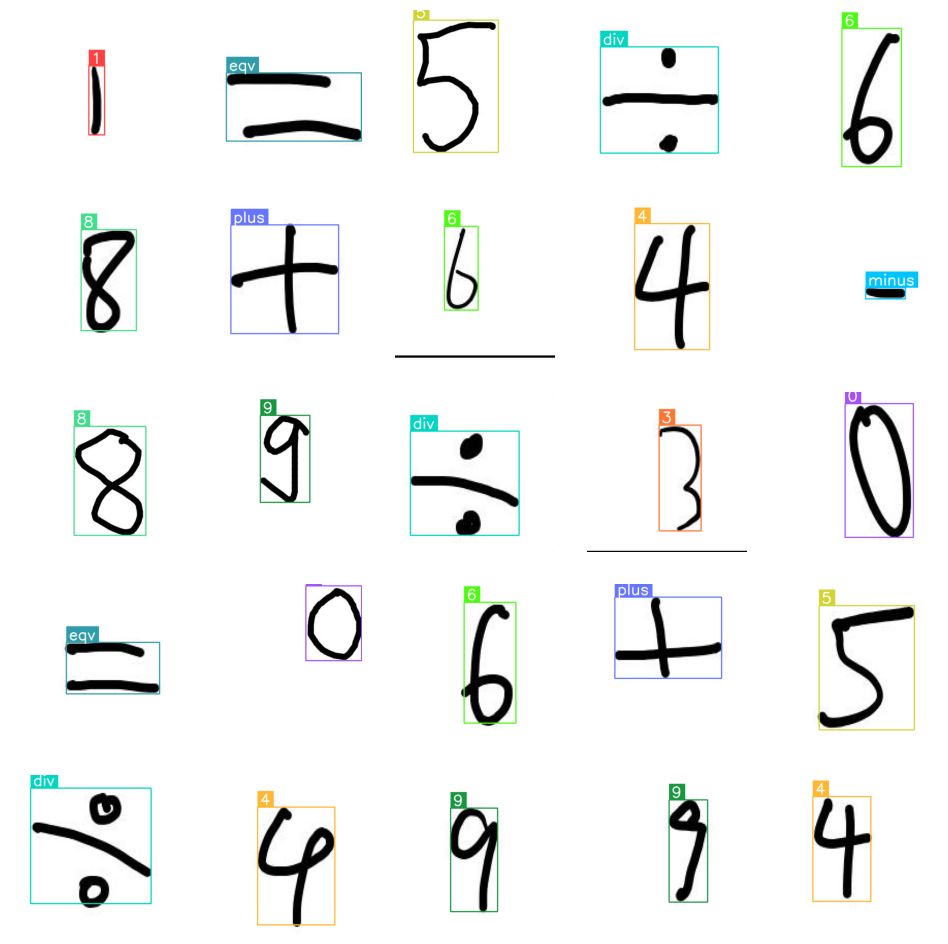

In [ ]:
import cv2
import json
import supervision as sv
from typing import List

def read_n_lines(file_path: str, n: int) -> List[str]:
    with open(file_path, 'r') as file:
        lines = [next(file).strip() for _ in range(n)]
    return lines

images = []
lines = read_n_lines(f"{dataset.location}/dataset/_annotations.train.jsonl", 25)
first = json.loads(lines[0])

CLASSES = first.get('prefix').replace("detect ", "").split(" ; ")

for line in lines:
    data = json.loads(line)
    image = cv2.imread(f"{dataset.location}/dataset/{data.get('image')}")
    (h, w, _) = image.shape
    detections = sv.Detections.from_lmm(
        lmm='paligemma',
        result=data.get('suffix'),
        resolution_wh=(w, h),
        classes=CLASSES)

    image = sv.BoundingBoxAnnotator(thickness=4).annotate(image, detections)
    image = sv.LabelAnnotator(text_scale=2, text_thickness=4).annotate(image, detections)
    images.append(image)

sv.plot_images_grid(images, (5, 5))

### Fetch the `big_vision` repository and install related dependencies

Download the `big_vision` repository to your Colab notebook from GitHub and install dependencies related to `big_vision` by running the following code.

In [ ]:
import os
import sys

# TPUs with
if "COLAB_TPU_ADDR" in os.environ:
  raise "It seems you are using Colab with remote TPUs which is not supported."

# Fetch big_vision repository if python doesn't know about it and install
# dependencies needed for this notebook.
if not os.path.exists("big_vision_repo"):
  !git clone --quiet --branch=main --depth=1 \
     https://github.com/google-research/big_vision big_vision_repo

# Append big_vision code to python import path
if "big_vision_repo" not in sys.path:
  sys.path.append("big_vision_repo")

# Install missing dependencies. Assume jax~=0.4.25 with GPU available.
!pip3 install -q "overrides" "ml_collections" "einops~=0.7" "sentencepiece"


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 3.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.2/43.2 kB 5.3 MB/s eta 0:00:00


### Set environment variables

Set the environment variables for `KAGGLE_USERNAME` and `KAGGLE_KEY`.

In [ ]:
import os
from google.colab import userdata

# Note: `userdata.get` is a Colab API. If you're not using Colab, set the env
# vars as appropriate or make your credentials available in ~/.kaggle/kaggle.json

os.environ["KAGGLE_USERNAME"] = userdata.get('KAGGLE_USERNAME')
os.environ["KAGGLE_KEY"] = userdata.get('KAGGLE_KEY')

### Import JAX and other dependencies

Import JAX and other dependencies required for PaliGemma, like TensorFlow and NumPy.

In [ ]:
import base64
import functools
import html
import io
import os
import warnings

import jax
import jax.numpy as jnp
import numpy as np
import ml_collections

import tensorflow as tf
import sentencepiece

from IPython.core.display import display, HTML
from PIL import Image
from tqdm.notebook import tqdm

# Import model definition from big_vision
from big_vision.models.proj.paligemma import paligemma
from big_vision.trainers.proj.paligemma import predict_fns

# Import big vision utilities
import big_vision.datasets.jsonl
import big_vision.utils
import big_vision.sharding

# Don't let TF use the GPU or TPUs
tf.config.set_visible_devices([], "GPU")
tf.config.set_visible_devices([], "TPU")

backend = jax.lib.xla_bridge.get_backend()
print(f"JAX version:  {jax.__version__}")
print(f"JAX platform: {backend.platform}")
print(f"JAX devices:  {jax.device_count()}")

JAX version:  0.4.26
JAX platform: gpu
JAX devices:  1


## Download and configure the model

In this step, you'll download the model checkpoint and configure it so that you can fine-tune it later on. This step shows you how to move model parameters into TPU memory, which is useful for fine-tuning models on devices with limited resources.

### Download the model checkpoint

PaliGemma includes several model variations. For this tutorial, you'll use the base [JAX/FLAX PaliGemma 3B weight model](https://www.kaggle.com/models/google/paligemma/jax/paligemma-3b-pt-224).

Download the `float16` version of the model checkpoint from Kaggle by running the following code. This process takes several minutes to complete.

In [ ]:
import os
import kagglehub

MODEL_PATH = "./pt_224_128.params.f16.npz"
if not os.path.exists(MODEL_PATH):
    print("Downloading the checkpoint from Kaggle, this could take a few minutes....")
    # Note: kaggle archive contains the same checkpoint in multiple formats.
    # Download only the float16 model.
    MODEL_PATH = kagglehub.model_download('google/paligemma/jax/paligemma-3b-pt-224', 'paligemma-3b-pt-224.f16.npz')
    print(f"Model path: {MODEL_PATH}")

TOKENIZER_PATH = "./paligemma_tokenizer.model"
if not os.path.exists(TOKENIZER_PATH):
    print("Downloading the model tokenizer...")
    !gsutil cp gs://big_vision/paligemma_tokenizer.model {TOKENIZER_PATH}
    print(f"Tokenizer path: {TOKENIZER_PATH}")

100%|██████████| 5.45G/5.45G [00:31<00:00, 187MB/s]


Model path: /root/.cache/kagglehub/models/google/paligemma/jax/paligemma-3b-pt-224/1/paligemma-3b-pt-224.f16.npz
Copying gs://big_vision/paligemma_tokenizer.model...
- [1 files][  4.1 MiB/  4.1 MiB]                                                
Operation completed over 1 objects/4.1 MiB.                                      
Tokenizer path: ./paligemma_tokenizer.model


### Configure the model

It's time to actually start configuring the model that you're going to use.

For this notebook, you need to be able to fit your model onto a T4 GPU. Having a limited resource like space constraints means that you have to be mindful of how your model is configured.

If you fine-tune every parameter, your model won't be able to run in the notebook environment. As a result, in this part of the notebook, you'll configure your model so that it has the ability to freeze some of the parameters, and only fine-tune the parameters that really need to be fine-tuned for the model to give you accurate results. In LLMs, parameters are said to be *frozen* when they are no longer actively being used to train the model.

In order to configure your model, you need to:

* Initialize the `model_config` as a [`FrozenConfigDict`](https://github.com/google/ml_collections/tree/master#frozenconfigdict) so that you can freeze some of the parameters and keep memory usage low
* Initialize an instance of the PaliGemma `Model` class using the `model_config` as its configurations
* Load the model parameters into RAM
* Define a `decode` function to sample outputs from the model

This code in this cell takes about a minute to run to completion.

In [ ]:
# Define model
model_config = ml_collections.FrozenConfigDict({
    "llm": {"vocab_size": 257_152},
    "img": {"variant": "So400m/14", "pool_type": "none", "scan": True, "dtype_mm": "float16"}
})
model = paligemma.Model(**model_config)
tokenizer = sentencepiece.SentencePieceProcessor(TOKENIZER_PATH)

# Load params - this can take up to 1 minute in T4 colabs.
params = paligemma.load(None, MODEL_PATH, model_config)

# Define `decode` function to sample outputs from the model.
decode_fn = predict_fns.get_all(model)['decode']
decode = functools.partial(decode_fn, devices=jax.devices(), eos_token=tokenizer.eos_id())

### Move model parameters into GPU/TPU memory

Now you need to move the model parameters into GPU/TPU memory. First, shard the parameters across the available GPUs, then load the parameters. Here, you'll load the parameters sequentially. This process takes longer than loading them simultaneously, but it requires more RAM than you have available in this notebook.

Finally, print out all of the parameters to see what type each individual parameter is cast to. Frozen parameters are kept as `float16`, while the trainable parameters are cast to `float32`. When you inspect the list, you'll see that most of the parameters have been frozen and are `float16`.

In [ ]:
# Create a pytree mask of the trainable params.
def is_trainable_param(name, param):  # pylint: disable=unused-argument
  if name.startswith("llm/layers/attn/"):  return True
  if name.startswith("llm/"):              return False
  if name.startswith("img/"):              return False
  raise ValueError(f"Unexpected param name {name}")
trainable_mask = big_vision.utils.tree_map_with_names(is_trainable_param, params)

# If more than one device is available (e.g. multiple GPUs) the parameters can
# be sharded across them to reduce HBM usage per device.
mesh = jax.sharding.Mesh(jax.devices(), ("data"))

data_sharding = jax.sharding.NamedSharding(
    mesh, jax.sharding.PartitionSpec("data"))

params_sharding = big_vision.sharding.infer_sharding(
    params, strategy=[('.*', 'fsdp(axis="data")')], mesh=mesh)

# Yes: Some donated buffers are not usable.
warnings.filterwarnings(
    "ignore", message="Some donated buffers were not usable")

@functools.partial(jax.jit, donate_argnums=(0,), static_argnums=(1,))
def maybe_cast_to_f32(params, trainable):
  return jax.tree.map(lambda p, m: p.astype(jnp.float32) if m else p,
                      params, trainable)

# Loading all params in simultaneous - albeit much faster and more succinct -
# requires more RAM than the T4 colab runtimes have by default.
# Instead we do it param by param.
params, treedef = jax.tree.flatten(params)
sharding_leaves = jax.tree.leaves(params_sharding)
trainable_leaves = jax.tree.leaves(trainable_mask)
for idx, (sharding, trainable) in enumerate(zip(sharding_leaves, trainable_leaves)):
  params[idx] = big_vision.utils.reshard(params[idx], sharding)
  params[idx] = maybe_cast_to_f32(params[idx], trainable)
  params[idx].block_until_ready()
params = jax.tree.unflatten(treedef, params)

# Print params to show what the model is made of.
def parameter_overview(params):
  for path, arr in big_vision.utils.tree_flatten_with_names(params)[0]:
    print(f"{path:80s} {str(arr.shape):22s} {arr.dtype}")

print(" == Model params == ")
parameter_overview(params)

 == Model params == 
img/Transformer/encoder_norm/bias                                                (1152,)                float16
img/Transformer/encoder_norm/scale                                               (1152,)                float16
img/Transformer/encoderblock/LayerNorm_0/bias                                    (27, 1152)             float16
img/Transformer/encoderblock/LayerNorm_0/scale                                   (27, 1152)             float16
img/Transformer/encoderblock/LayerNorm_1/bias                                    (27, 1152)             float16
img/Transformer/encoderblock/LayerNorm_1/scale                                   (27, 1152)             float16
img/Transformer/encoderblock/MlpBlock_0/Dense_0/bias                             (27, 4304)             float16
img/Transformer/encoderblock/MlpBlock_0/Dense_0/kernel                           (27, 1152, 4304)       float16
img/Transformer/encoderblock/MlpBlock_0/Dense_1/bias                             (2

## Prepare to tune the model

Now that your model is configured, you can tune it. In this step, you'll create your model's inputs as well as the training and validation iterators, view the training examples, and define the training and validation loops.

### Create model inputs

The model checkpoint you're using has already been trained on images of various aspect ratios that have been resized to 224x224 pixels, and to handle tokenized texts.

The code below defines three functions that you'll use in the next step create the model's inputs:

* **`preprocess_image`:** Normalizes the image data. In this case, pre-processing converts the passed-in image to greyscale, removes the alpha layer, and resizes the passed-in image to the size required by the model for image inputs (224x224 pixels).
* **`preprocess_tokens`:** Splits the tokens up and adds flags to mark whether a token is a prefix or suffix token. These flags will be used later on in the code, during the training step and the evaluation loop.
* **`postprocess_tokens`:** Removes any tokens left at and/or after the end-of-sequence (EOS) token and returns the remaining decoded tokens.


In [ ]:
def preprocess_image(image, size=224):
  # Model has been trained to handle images of different aspects ratios
  # resized to 224x224 in the range [-1, 1]. Bilinear and antialias resize
  # options are helpful to improve quality in some tasks.
  image = np.asarray(image)
  if image.ndim == 2:  # Convert image without last channel into greyscale.
    image = np.stack((image,)*3, axis=-1)
  image = image[..., :3]  # Remove alpha layer.
  assert image.shape[-1] == 3

  image = tf.constant(image)
  image = tf.image.resize(image, (size, size), method='bilinear', antialias=True)
  return image.numpy() / 127.5 - 1.0  # [0, 255]->[-1,1]

def preprocess_tokens(prefix, suffix=None, seqlen=None):
  # Model has been trained to handle tokenized text composed of a prefix with
  # full attention and a suffix with causal attention.
  separator = "\n"
  tokens = tokenizer.encode(prefix, add_bos=True) + tokenizer.encode(separator)
  mask_ar = [0] * len(tokens)    # 0 to use full attention for prefix.
  mask_loss = [0] * len(tokens)  # 0 to not use prefix tokens in the loss.

  if suffix:
    suffix = tokenizer.encode(suffix, add_eos=True)
    tokens += suffix
    mask_ar += [1] * len(suffix)    # 1 to use causal attention for suffix.
    mask_loss += [1] * len(suffix)  # 1 to use suffix tokens in the loss.

  mask_input = [1] * len(tokens)    # 1 if it's a token, 0 if padding.
  if seqlen:
    padding = [0] * max(0, seqlen - len(tokens))
    tokens = tokens[:seqlen] + padding
    mask_ar = mask_ar[:seqlen] + padding
    mask_loss = mask_loss[:seqlen] + padding
    mask_input = mask_input[:seqlen] + padding

  return jax.tree.map(np.array, (tokens, mask_ar, mask_loss, mask_input))

def postprocess_tokens(tokens):
  tokens = tokens.tolist()  # np.array to list[int]
  try:  # Remove tokens at and after EOS if any.
    eos_pos = tokens.index(tokenizer.eos_id())
    tokens = tokens[:eos_pos]
  except ValueError:
    pass
  return tokenizer.decode(tokens)

### Create the training and validation iterators

Create two iterators:

*   A **training iterator** to allow the training process to go through the data in chunks rather than processing it all at once. This allows you to do some data pre-processing before use.
*   A **validation iterator** that allows the training process to iterate over the validation dataset to see how well the tuned model aligned with the provided results.

In [ ]:
SEQLEN = 128

train_dataset = big_vision.datasets.jsonl.DataSource(
    os.path.join(dataset.location, "dataset/_annotations.train.jsonl"),
    fopen_keys={"image": f"{dataset.location}/dataset"})

val_dataset = big_vision.datasets.jsonl.DataSource(
    os.path.join(dataset.location, "dataset/_annotations.valid.jsonl"),
    fopen_keys={"image": f"{dataset.location}/dataset"})


def train_data_iterator():
  """Never ending iterator over training examples."""
  # Shuffle examples and repeat so one can train for many epochs.
  dataset = train_dataset.get_tfdata().shuffle(1_000).repeat()
  for example in dataset.as_numpy_iterator():
    image = Image.open(io.BytesIO(example["image"]))
    image = preprocess_image(image)

    prefix = example["prefix"].decode().lower()
    suffix = example["suffix"].decode().lower()
    tokens, mask_ar, mask_loss, _ = preprocess_tokens(prefix, suffix, SEQLEN)
    label, _, _, _ = preprocess_tokens(suffix, seqlen=SEQLEN)

    yield {
        "image": np.asarray(image),
        "text": np.asarray(tokens),
        "label": np.asarray(label),
        "mask_ar": np.asarray(mask_ar),
        "mask_loss": np.asarray(mask_loss),
    }


def validation_data_iterator():
  """Single iterator over validation examples."""
  for example in val_dataset.get_tfdata(ordered=True).as_numpy_iterator():
    image = Image.open(io.BytesIO(example["image"]))
    image = preprocess_image(image)

    prefix = example["prefix"].decode().lower()
    suffix = example["suffix"].decode().lower()
    tokens, mask_ar, _, mask_input = preprocess_tokens(prefix, seqlen=SEQLEN)
    label, _, _, _ = preprocess_tokens(suffix, seqlen=SEQLEN)

    yield {
        "image": np.asarray(image),
        "text": np.asarray(tokens),
        "label": np.asarray(label),
        "mask_ar": np.asarray(mask_ar),
        "mask_input": np.asarray(mask_input),
    }


### View training examples

In this notebook, the training data contains 90 images that are paired with long descriptions of what's depicted in the image.

**Note:** Normal training data sets that are meant to be used for practical use cases should contain more images, but this notebook limits the number of data points so that you can train the model in a reasonable amount of time for an example.

The code below prints a random selection of images with their descriptions from the training data set so that you can see what the images and descriptions your model is trained on looks like. Each image is displayed in as a 128x128 pixel JPEG, with the description printed next to the image to the right.

Training examples



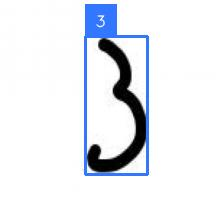
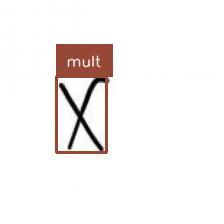
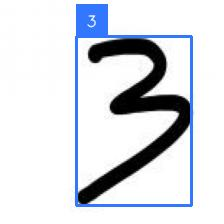
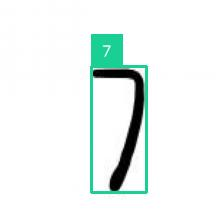

In [ ]:
def split_and_keep_second_part(s):
    parts = s.split('\n', 1)
    if len(parts) > 1:
        return parts[1]
    return s

def render_inline(image, resize=(128, 128)):
    """Convert image into inline html."""
    image = Image.fromarray(image)
    image.resize(resize)
    with io.BytesIO() as buffer:
        image.save(buffer, format='jpeg')
        image_b64 = str(base64.b64encode(buffer.getvalue()), "utf-8")
        return f"data:image/jpeg;base64,{image_b64}"

def render_example(image, caption):
    image = ((image + 1)/2 * 255).astype(np.uint8)  # [-1,1] -> [0, 255]
    h, w, _ = image.shape
    try:
        detections = sv.Detections.from_lmm(
            lmm='paligemma',
            result=caption,
            resolution_wh=(w, h),
            classes=CLASSES)
        image = sv.BoundingBoxAnnotator().annotate(image, detections)
        image = sv.LabelAnnotator().annotate(image, detections)
    except:
        print(caption)
    return f"""
<div style="display: inline-flex; align-items: center; justify-content: center;">
    <img style="width:128px; height:128px;" src="{render_inline(image, resize=(64,64))}" />
    <p style="width:256px; margin:10px; font-size:small;">{html.escape(caption)}</p>
</div>
"""

html_out = ""
for idx, example in zip(range(4), train_data_iterator()):
    caption = postprocess_tokens(example["text"])  # detokenize model input.
    caption = split_and_keep_second_part(caption)
    html_out += render_example(example["image"], caption)

print("Training examples")
display(HTML(html_out))

### Define the training and evaluation loops

Define the training loop to train the model on the provided dataset, and the evaluation loop to look at all of the examples in the validation dataset and make its predictions.

#### Defining the training loop

The `update_fn` function defines the training step. During the training step, the loss per example is calculated and stochastic gradient descent (SGD) is applied to the trainable parameters.

Recall that earlier in the notebook, you included flags in the `preprocess_tokens` function that included `mask_loss`. You'll use the `mask_loss` flag here to exclude prefix and padded tokens from the loss. Without it, the loss calculation will be skewed. You also need to normalize each example, since each of them has a different number of tokens. After the prefix and padded tokens have been excluded and the examples have been normalized, you can calculate the loss per example.

The training step also includes a function to apply an SGD to optimize the training.

#### Defining the evaluation loop

The `make_predictions` function is your evaluation loop. The evaluation loop is fairly straight forward with one notable change. If you recall from the beginning of the notebook, you only have 90 examples in your training data set. This is a very small amount of training examples, and your model ends up not having enough examples for the batch size when you run the training. This means that in the evaluation loop, you need to pad the batch by repeating examples.

To make sure that your evaluation loop only counts actual examples and not the padded examples, you have to apply a mask to the padded examples that excludes them from the output.

In [ ]:
# The main update_fn using a simple stochastic gradient descent (SGD).
@functools.partial(jax.jit, donate_argnums=(0,))
def update_fn(params, batch, learning_rate):
  imgs, txts, mask_ar = batch["image"], batch["text"], batch["mask_ar"]

  def loss_fn(params):
    text_logits, _ = model.apply({"params": params}, imgs, txts[:, :-1], mask_ar[:, :-1], train=True)
    logp = jax.nn.log_softmax(text_logits, axis=-1)

    # The model takes as input txts[:, :-1] but the loss is defined as predicting
    # next tokens txts[:, 1:]. Additionally, mask_loss[:, 1:] indicates which tokens
    # are part of the loss (e.g. prefix and padded tokens are not included).
    mask_loss = batch["mask_loss"][:, 1:]
    targets = jax.nn.one_hot(txts[:, 1:], text_logits.shape[-1])

    # Compute the loss per example. i.e. the mean of per token pplx.
    # Since each example has a different number of tokens we normalize it.
    token_pplx = jnp.sum(logp * targets, axis=-1)  # sum across vocab_size.
    example_loss = -jnp.sum(token_pplx * mask_loss, axis=-1)  # sum across seq_len.
    example_loss /= jnp.clip(jnp.sum(mask_loss, -1), 1)  # weight by num of tokens.

    # batch_loss: mean of per example loss.
    return jnp.mean(example_loss)

  loss, grads = jax.value_and_grad(loss_fn)(params)

  # Apply gradients to trainable params using SGD.
  def apply_grad(param, gradient, trainable):
    if not trainable: return param
    return param - learning_rate * gradient

  params = jax.tree_util.tree_map(apply_grad, params, grads, trainable_mask)

  return params, loss

# Evaluation/inference loop.
def make_predictions(data_iterator, *, num_examples=None,
                     batch_size=4, seqlen=SEQLEN, sampler="greedy"):
  outputs = []
  while True:
    # Construct a list of examples in the batch.
    examples = []
    try:
      for _ in range(batch_size):
        examples.append(next(data_iterator))
        examples[-1]["_mask"] = np.array(True)  # Indicates true example.
    except StopIteration:
      if len(examples) == 0:
        return outputs

    # Not enough examples to complete a batch. Pad by repeating last example.
    while len(examples) % batch_size:
      examples.append(dict(examples[-1]))
      examples[-1]["_mask"] = np.array(False)  # Indicates padding example.

    # Convert list of examples into a dict of np.arrays and load onto devices.
    batch = jax.tree.map(lambda *x: np.stack(x), *examples)
    batch = big_vision.utils.reshard(batch, data_sharding)

    # Make model predictions
    tokens = decode({"params": params}, batch=batch,
                    max_decode_len=seqlen, sampler=sampler)

    # Fetch model predictions to device and detokenize.
    tokens, mask = jax.device_get((tokens, batch["_mask"]))
    tokens = tokens[mask]  # remove padding examples.
    labels = [postprocess_tokens(e["label"]) for e in examples]
    responses = [postprocess_tokens(t) for t in tokens]

    # Append to html output.
    for example, label, response in zip(examples, labels, responses):
      outputs.append((example["image"], label, response))
      if num_examples and len(outputs) >= num_examples:
        return outputs


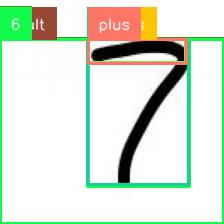
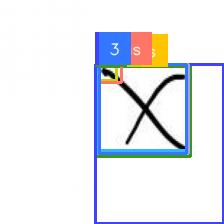
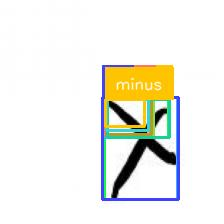
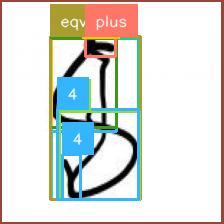

In [ ]:
html_out = ""
for image, _, caption in make_predictions(validation_data_iterator(), num_examples=4, batch_size=4):
  html_out += render_example(image, caption)
display(HTML(html_out))

## Tune the model

Now that you've set everything up and taken a look at the training data, it's time to finally tune the model. The code below runs the training loop for the model for 64 steps and prints the learning rate (`lr` in the printed output) and loss rate for each step.

Every 16 steps, the model prints what its predictions are at that step in the training. This code prints out predictions for the same set of images so that you can see the model's ability to predict descriptions improve over time.

At earlier steps in the training, there's likely issues with the descriptions, such as repeated sentences as the model gets stuck in its predictive loop or unfinished sentences. The model's predictions become steadily more accurate as training progresses. By step 64, the model's predictions should closely resemble the descriptions provided by the training data.

This process takes around 15 minutes to complete on T4 TPUs.

step:  1/64   lr: 0.00083   loss: 5.8282
step:  2/64   lr: 0.00167   loss: 4.2337
step:  3/64   lr: 0.00250   loss: 2.9162
step:  4/64   lr: 0.00333   loss: 2.9888
step:  5/64   lr: 0.00417   loss: 3.7543
step:  6/64   lr: 0.00500   loss: 3.4869
step:  7/64   lr: 0.00500   loss: 2.8439
step:  8/64   lr: 0.00499   loss: 2.7128
Model predictions at step 8



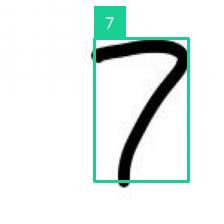
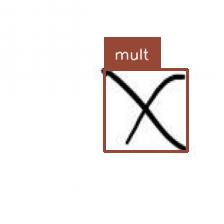
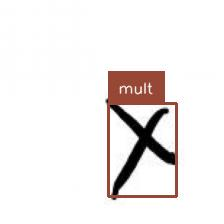
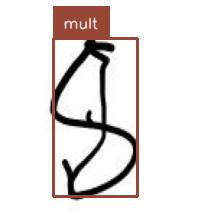

step:  9/64   lr: 0.00497   loss: 2.9998
step: 10/64   lr: 0.00494   loss: 2.8678
step: 11/64   lr: 0.00491   loss: 2.7352
step: 12/64   lr: 0.00487   loss: 2.5357
step: 13/64   lr: 0.00483   loss: 3.3715
step: 14/64   lr: 0.00478   loss: 3.3778
step: 15/64   lr: 0.00472   loss: 2.8900
step: 16/64   lr: 0.00465   loss: 2.5499
Model predictions at step 16



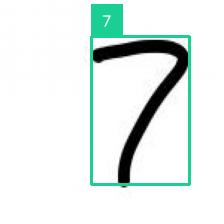
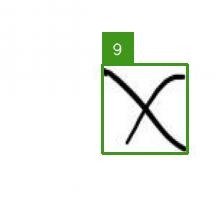
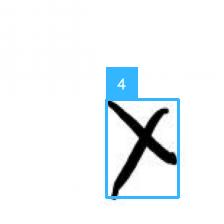
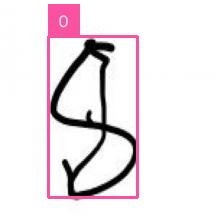

step: 17/64   lr: 0.00458   loss: 2.6035
step: 18/64   lr: 0.00451   loss: 2.6572
step: 19/64   lr: 0.00442   loss: 2.7663
step: 20/64   lr: 0.00434   loss: 2.4841
step: 21/64   lr: 0.00424   loss: 2.4350
step: 22/64   lr: 0.00415   loss: 2.4289
step: 23/64   lr: 0.00404   loss: 2.5106
step: 24/64   lr: 0.00394   loss: 2.3384
Model predictions at step 24



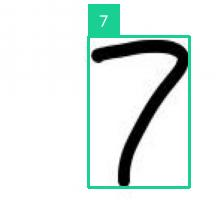
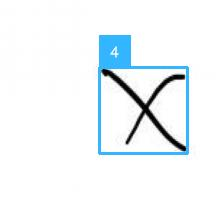
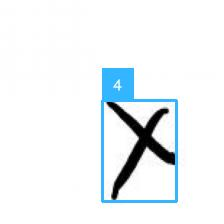
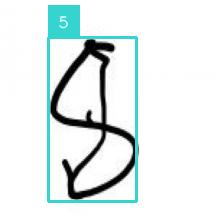

step: 25/64   lr: 0.00383   loss: 2.2906
step: 26/64   lr: 0.00371   loss: 2.5781
step: 27/64   lr: 0.00359   loss: 2.7295
step: 28/64   lr: 0.00347   loss: 2.6152
step: 29/64   lr: 0.00335   loss: 2.4637
step: 30/64   lr: 0.00322   loss: 2.2896
step: 31/64   lr: 0.00309   loss: 2.5552
step: 32/64   lr: 0.00296   loss: 2.5247
Model predictions at step 32



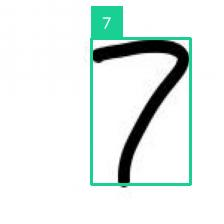
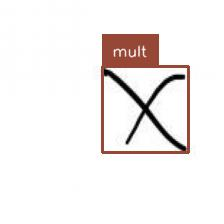
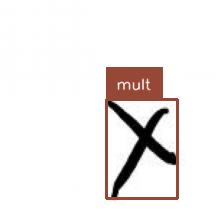
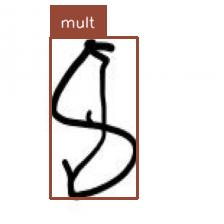

step: 33/64   lr: 0.00283   loss: 2.2635
step: 34/64   lr: 0.00270   loss: 2.3190
step: 35/64   lr: 0.00257   loss: 2.7259
step: 36/64   lr: 0.00243   loss: 2.2275
step: 37/64   lr: 0.00230   loss: 2.2464
step: 38/64   lr: 0.00217   loss: 2.3005
step: 39/64   lr: 0.00204   loss: 2.3608
step: 40/64   lr: 0.00191   loss: 2.4620
Model predictions at step 40



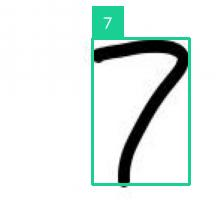
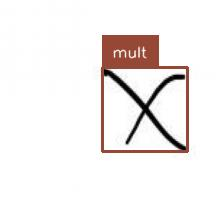
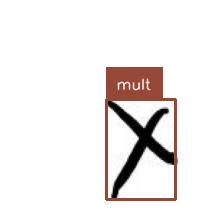
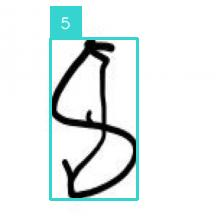

step: 41/64   lr: 0.00178   loss: 2.3459
step: 42/64   lr: 0.00165   loss: 2.2039
step: 43/64   lr: 0.00153   loss: 2.3946
step: 44/64   lr: 0.00141   loss: 2.1198
step: 45/64   lr: 0.00129   loss: 2.4954
step: 46/64   lr: 0.00117   loss: 2.3431
step: 47/64   lr: 0.00106   loss: 2.3990
step: 48/64   lr: 0.00096   loss: 2.3164
Model predictions at step 48



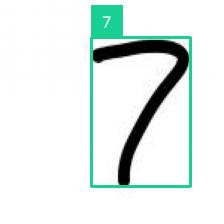
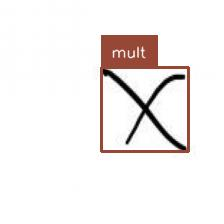
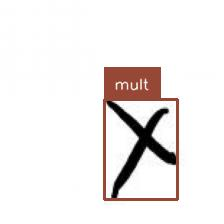
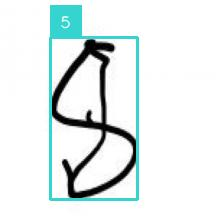

step: 49/64   lr: 0.00085   loss: 2.1605
step: 50/64   lr: 0.00076   loss: 2.3063
step: 51/64   lr: 0.00066   loss: 2.2940
step: 52/64   lr: 0.00058   loss: 2.2904
step: 53/64   lr: 0.00049   loss: 2.2708
step: 54/64   lr: 0.00042   loss: 2.2300
step: 55/64   lr: 0.00035   loss: 2.2392
step: 56/64   lr: 0.00028   loss: 2.1673
Model predictions at step 56



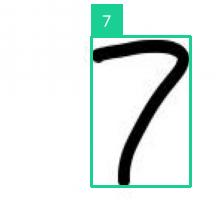
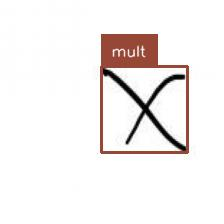
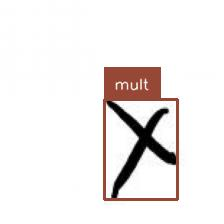
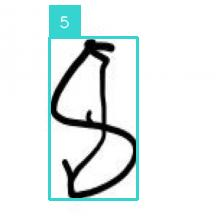

step: 57/64   lr: 0.00022   loss: 2.3202
step: 58/64   lr: 0.00017   loss: 2.3993
step: 59/64   lr: 0.00013   loss: 2.3779
step: 60/64   lr: 0.00009   loss: 2.0864
step: 61/64   lr: 0.00006   loss: 2.3988
step: 62/64   lr: 0.00003   loss: 2.4061
step: 63/64   lr: 0.00001   loss: 2.2636
step: 64/64   lr: 0.00000   loss: 2.3142
Model predictions at step 64



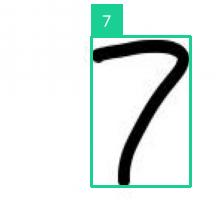
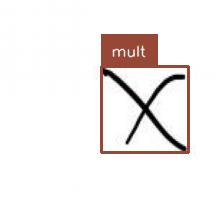
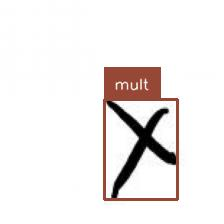
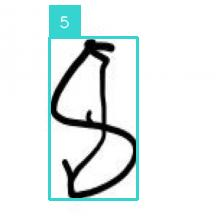

CPU times: user 12min 8s, sys: 773 ms, total: 12min 9s
Wall time: 12min 9s


In [ ]:
# Run a short training loop with cosine learning rate schedule.
#
# Note: the first step can be quite slow on some machines (up to several minutes)
# due to XLA compilation of the jax.jit'd function.
#
%%time

BATCH_SIZE = 8
TRAIN_EXAMPLES = 512
LEARNING_RATE = 0.005

TRAIN_STEPS = TRAIN_EXAMPLES // BATCH_SIZE
EVAL_STEPS = TRAIN_STEPS // 8

train_data_it = train_data_iterator()

sched_fn = big_vision.utils.create_learning_rate_schedule(
    total_steps=TRAIN_STEPS+1, base=LEARNING_RATE,
    decay_type="cosine", warmup_percent=0.10)

for step in range(1, TRAIN_STEPS+1):
  # Make list of N training examples.
  examples = [next(train_data_it) for _ in range(BATCH_SIZE)]

  # Convert list of examples into a dict of np.arrays and load onto devices.
  batch = jax.tree.map(lambda *x: np.stack(x), *examples)
  batch = big_vision.utils.reshard(batch, data_sharding)

  # Training step and report training loss
  learning_rate = sched_fn(step)
  params, loss = update_fn(params, batch, learning_rate)

  loss = jax.device_get(loss)
  print(f"step: {step:2d}/{TRAIN_STEPS:2d}   lr: {learning_rate:.5f}   loss: {loss:.4f}")

  if (step % EVAL_STEPS) == 0:
    print(f"Model predictions at step {step}")
    html_out = ""
    for image, _, caption in make_predictions(
        validation_data_iterator(), num_examples=4, batch_size=4):
      html_out += render_example(image, caption)
    display(HTML(html_out))


## Evaluate fine-tuned model


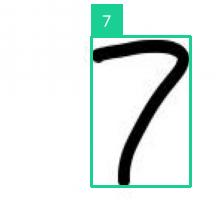
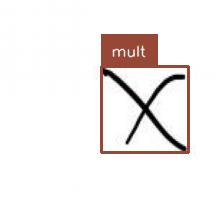
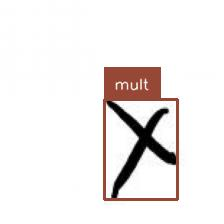
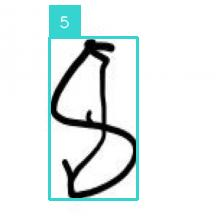
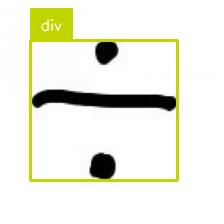
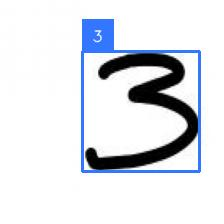
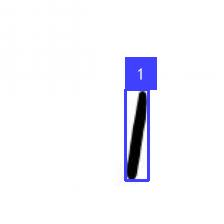
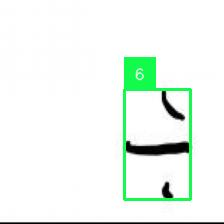
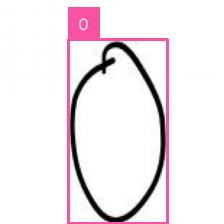
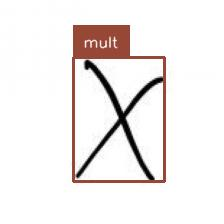
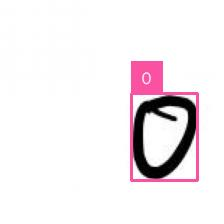
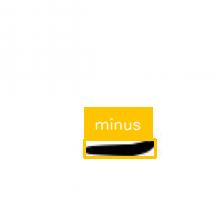
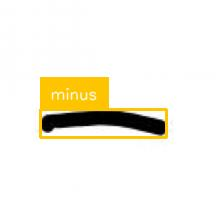
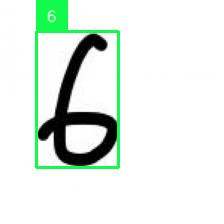
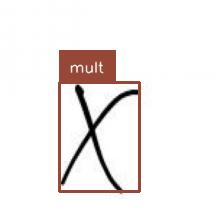
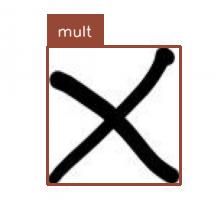

In [ ]:
# @title Visualize results
html_out = ""
for image, _, caption in make_predictions(validation_data_iterator(), num_examples=16, batch_size=8):
  html_out += render_example(image, caption)
display(HTML(html_out))

In [ ]:
# @title Collect predictions
targets = []
predictions = []

for image, label, prediction in make_predictions(validation_data_iterator(), num_examples=512, batch_size=8):
    h, w, _ = image.shape
    target = sv.Detections.from_lmm(
        lmm='paligemma',
        result=label,
        resolution_wh=(w, h),
        classes=CLASSES)
    targets.append(target)
    prediction = sv.Detections.from_lmm(
        lmm='paligemma',
        result=prediction,
        resolution_wh=(w, h),
        classes=CLASSES)
    prediction.confidence = np.ones(len(prediction))
    predictions.append(prediction)

In [ ]:
# @title Calculate mAP
mean_average_precision = sv.MeanAveragePrecision.from_detections(
    predictions=predictions,
    targets=targets,
)

print(f"map50_95: {mean_average_precision.map50_95:.2f}")
print(f"map50: {mean_average_precision.map50:.2f}")
print(f"map75: {mean_average_precision.map75:.2f}")

map50_95: 0.83
map50: 0.94
map75: 0.92


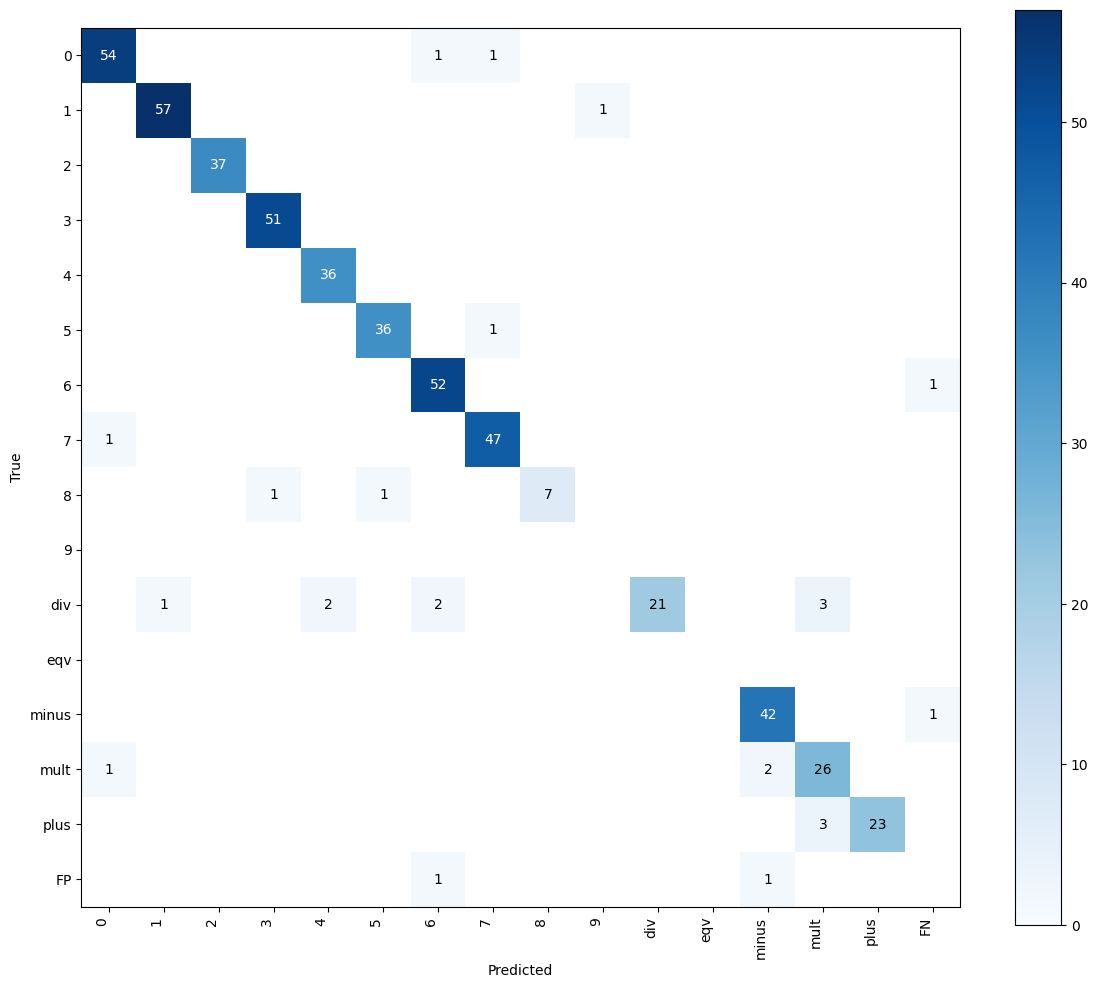

In [ ]:
# @title Calculate Confusion Matrix
confusion_matrix = sv.ConfusionMatrix.from_detections(
    predictions=predictions,
    targets=targets,
    classes=CLASSES
)

_ = confusion_matrix.plot()

## Save fine-tuned model locally

In [ ]:
flat, _ = big_vision.utils.tree_flatten_with_names(params)
with open("/content/fine-tuned-paligemma-3b-pt-224.f16.npz", "wb") as f:
  np.savez(f, **{k: v for k, v in flat})

# Congratulations

You now have a fine-tuned PaliGemma model! Next, it will be time to deploy it so we can get predictions. You will soon be able to do this in two lines of code with [Roboflow Inference](https://github.com/roboflow/inference); stay tuned for updates.

⭐️ If you enjoyed this notebook, [**star the Roboflow Notebooks repo**](https://https://github.com/roboflow/notebooks) (and [**supervision**](https://github.com/roboflow/supervision) while you're at it) and let us know what tutorials you'd like to see us do next. ⭐️